In [36]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from scipy import stats

In [37]:
def w2f(w):
    return (299792458/w)*0.01 # AA to THz

def f2w(f):
    return (299792458/f)*0.01 # THz to AA

In [38]:
z = 0.017670
lambda_, intensity = np.loadtxt('data/ngc1275.csv', delimiter=',', unpack = True, usecols = (0,1)) # Angstrom, W / (m^2 Hz)
lambda_ /= 1+z
frequency = w2f(lambda_)

### Continuum Fitting

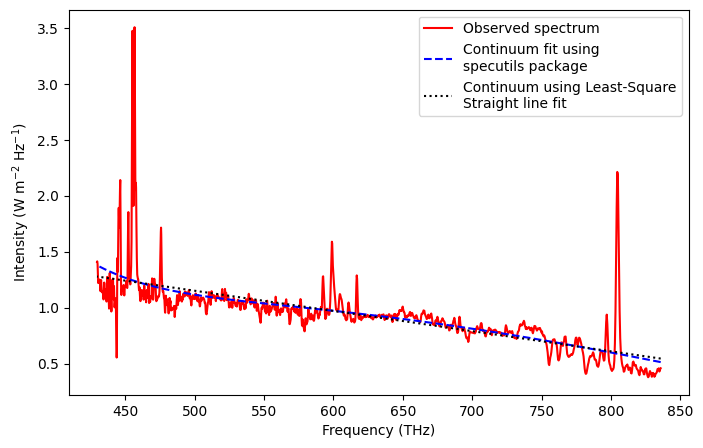

In [39]:
plt.figure(figsize=(8,5))
plt.plot(frequency, intensity, 'r', label='Observed spectrum')  

# using specutils package
spectrum = Spectrum1D(flux=intensity*u.Jy, spectral_axis=lambda_*u.angstrom)
g1_fit = fit_generic_continuum(spectrum)
y_continuum_2 = g1_fit(lambda_*u.angstrom)
flux = intensity/y_continuum_2
plt.plot(frequency, y_continuum_2, 'b--', label='Continuum fit using\nspecutils package')

# using least square fitting
slope, intercept, r_value, p_value, std_err = stats.linregress(frequency, intensity)
y_continuum_1 = slope*frequency+intercept
plt.plot(frequency, y_continuum_1, 'k:', label='Continuum using Least-Square\nStraight line fit')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()

After Continuum Subtraction

Text(0, 0.5, 'Intensity (W m$^{-2}$ Hz$^{-1}$)')

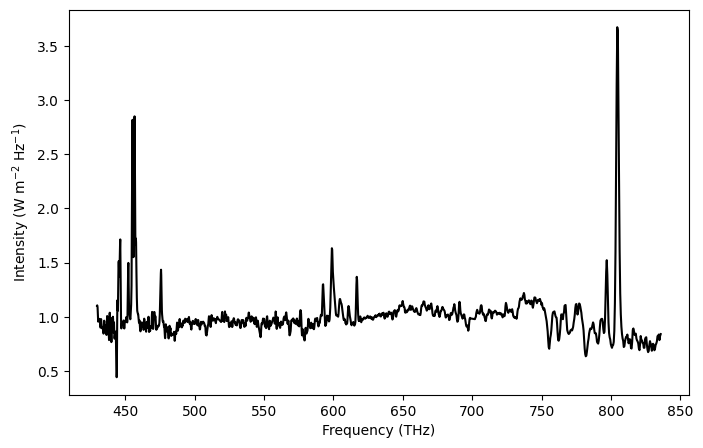

In [40]:
plt.figure(figsize=(8,5))

flux = intensity/y_continuum_1
plt.plot(frequency, flux, 'k')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')

Applying Median Filter

For kernel = 1,
$$
f[i] = \text{median}(f[i-1],f[i],f[i+1])
$$

Text(0, 0.5, 'Intensity (W m$^{-2}$ Hz$^{-1}$)')

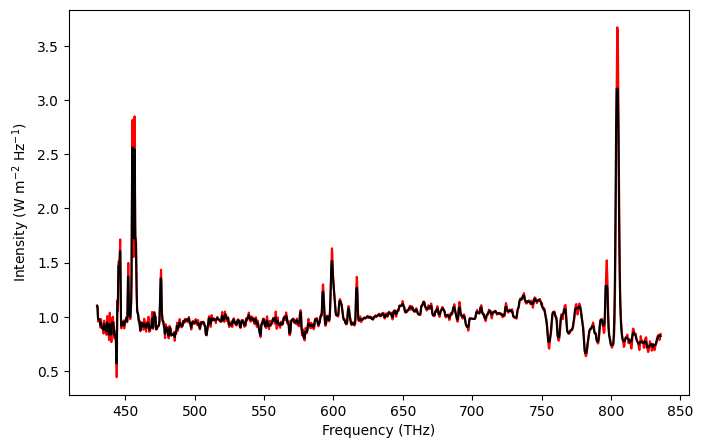

In [41]:
plt.figure(figsize=(8,5))

def medfiltt(x, k=3):
    n = len(x)
    xs = np.zeros(n)
    for i in range(n):
        a = i-k if i >= k else 0
        b = i+k if i <= n-k else -1 
        xs[i] = np.median(x[a:b])
    return xs

flux_smooth = medfiltt(flux)
plt.plot(frequency, flux, 'r')
plt.plot(frequency, flux_smooth, 'k')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')

### Finding peaks

[806.2626605  599.39055154 475.95911191 458.09277888]


Text(0, 0.5, 'Intensity (W m$^{-2}$ Hz$^{-1}$)')

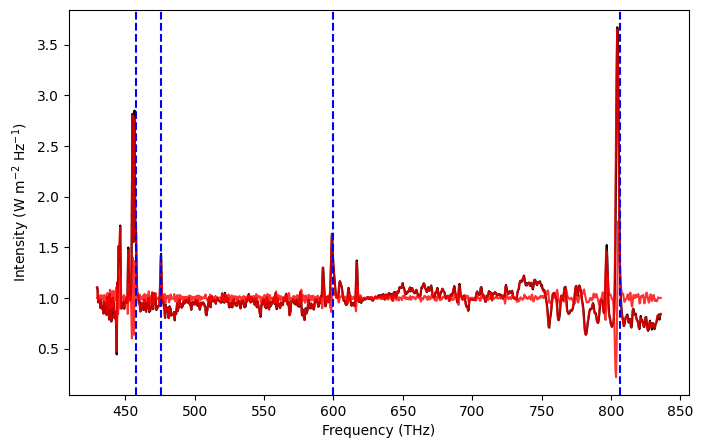

In [42]:
plt.figure(figsize=(8,5))
plt.plot(frequency, flux, 'k')

def dydx(y, order=1):
    dy = np.zeros(len(y))
    if order == 1:
        for i in range(1, len(y)-1):
            dy[i] = (y[i+1]-y[i-1])/2
            
    elif order == 2:
        for i in range(2, len(y)-2):
            dy[i] = (-y[i+2] + 8*y[i+1] - 8*y[i-1] + y[i-2])/12
            
    elif order == 3:
        for i in range(3, len(y)-3):
            dy[i] = (y[i+3] - 9*y[i+2] + 15*y[i+1] - 15*y[i-1] + 9*y[i-2] - y[i-3])/60
    
    elif order == 4:
        for i in range(4, len(y)-4):
            dy[i] = (-y[i+4] + (4*280/105)*y[i+3] - 56*y[i+2] + 224*y[i+1] - 224*y[i-1] + 56*y[i-2] - (4*280/105)*y[i-3] + y[i+4])/280
            
    return dy[:]

threshold = 0.080
flux_smooth = medfiltt(flux, 1)
dy4 = dydx(flux_smooth, 4)
line_fs = frequency[np.where((dy4>threshold) & (flux_smooth>1.3))]
realines = []
i = 0
while i < len(line_fs):
    realines.append(line_fs[i])
    for j in range(i+1, len(line_fs)):
        if abs(line_fs[i] - line_fs[j]) <= 10:
            i += 1
    i += 1
    
realines = np.array(realines)
print(realines)
plt.plot(frequency, dy4+1, 'r', alpha=0.8)
plt.plot(frequency, flux_smooth, 'r', alpha=0.8)
for line in realines:
    plt.axvline(line, color='b', linestyle='--')
# for line in line_fs:
#     plt.axvline(line, color='k', linestyle='--')

plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')

### Gaussian fitting the emission lines

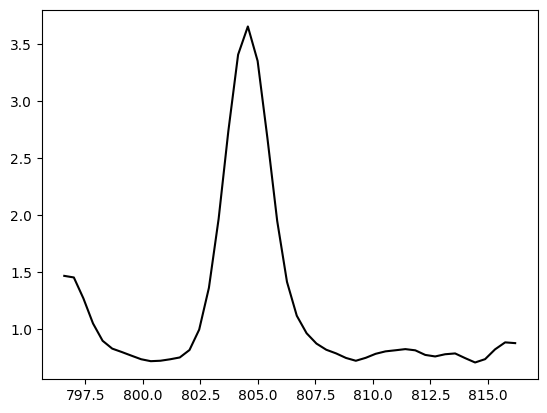

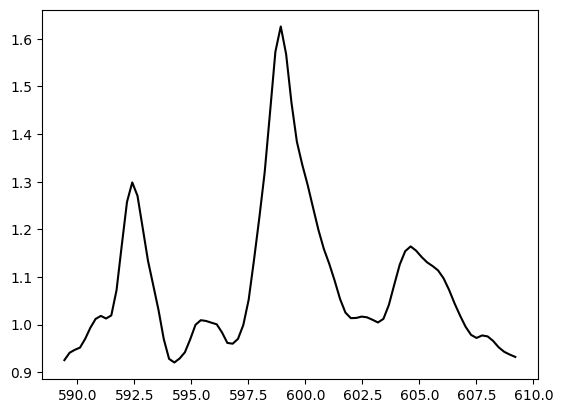

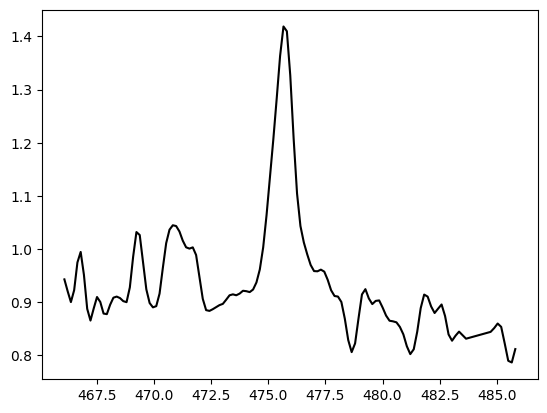

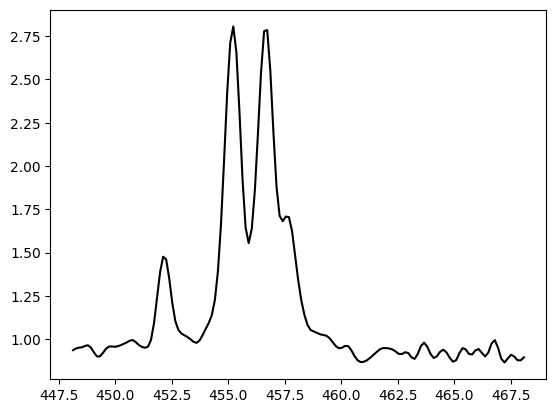

In [43]:

for line in realines:
    window = np.where((frequency > line-10) & (frequency < line+10))
    plt.plot(frequency[window], flux_smooth[window], 'k', alpha=1)
    plt.show()   

Line strength for f = 804.557 THz: 2.336


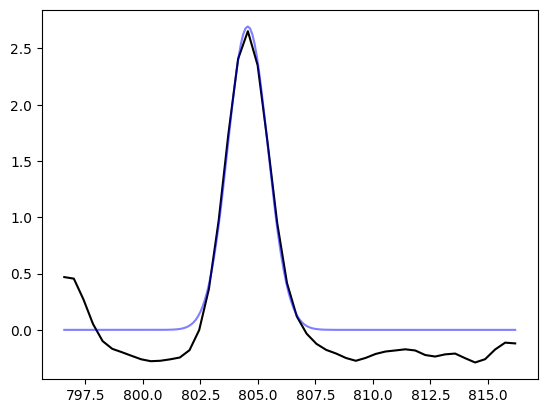

Line strength for f = 599.117 THz: 0.490


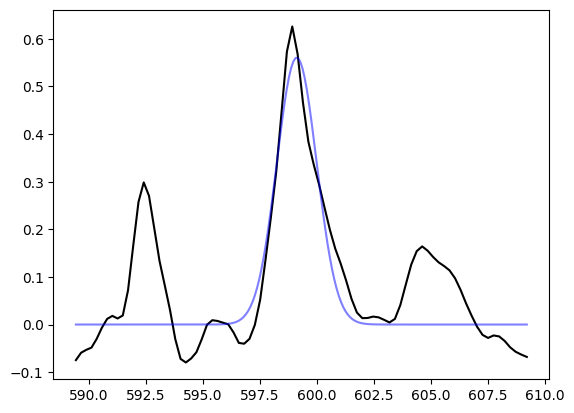

Line strength for f = 475.674 THz: 0.154


C:\Users\beast\AppData\Local\Temp\ipykernel_10636\1722924952.py:4: RuntimeWarning: overflow encountered in exp
  y = amplitude*np.exp(-((x-mean)**2)/(2*stddev))


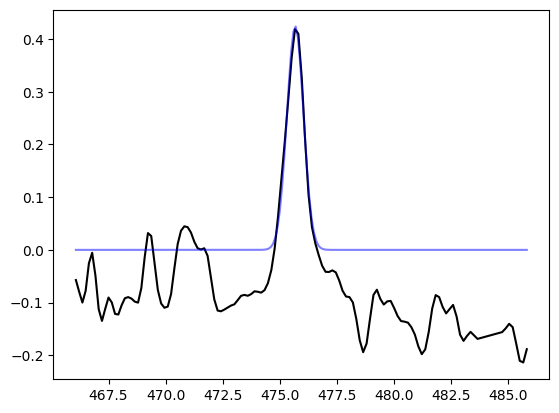

Line strength for f = 456.129 THz: 1.663


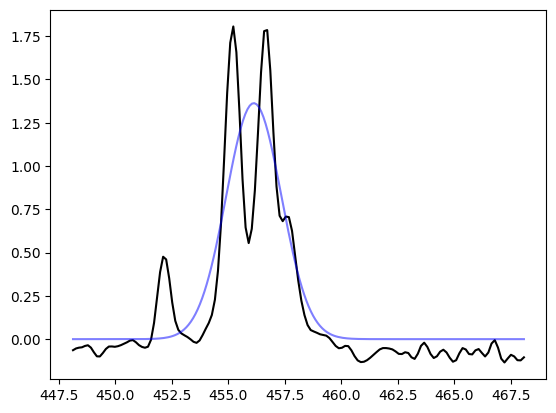

In [52]:
from scipy.optimize import curve_fit 

def gaussian(x, amplitude=1, mean=0, stddev=1): 
    y = amplitude*np.exp(-((x-mean)**2)/(2*stddev)) 
    return y 

final_lines = []

for line in realines:
    window = np.where((frequency > line-10) & (frequency < line+10))
    xs = frequency[window]
    ys = flux_smooth[window] - 1
    plt.plot(xs, ys, 'k', alpha=1)
    params, cov = curve_fit(gaussian, xs, ys, p0=[np.max(ys), line, 5])
    fit_x = np.linspace(xs[-1], xs[0], 200)
    fit_y = gaussian(fit_x, params[0], params[1], params[2]) 
    plt.plot(fit_x, fit_y, 'b-', label='fit', alpha=0.5)
    print(f'Line strength for f = {params[1]:.3f} THz: {params[0]*np.sqrt(params[2]):.3f}')
    final_lines.append(params[1])
    plt.show()

In [53]:
del final_lines[-1]
final_lines

[804.5573105335643, 599.1168697086532, 475.6740839630686]

Handling double peaks

Area under fit1: 0.680888398841547
Area under fit2: 0.7334614588416305


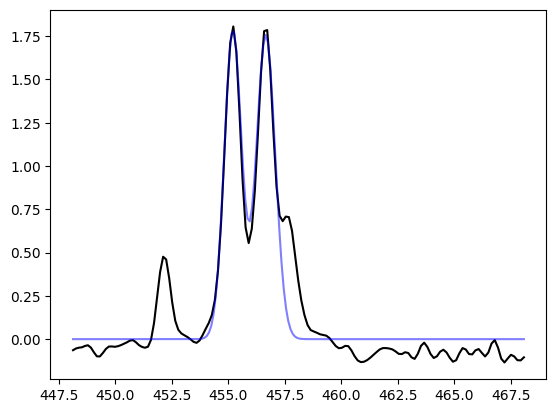

In [54]:
line = realines[3]
line1 = 455
line2 = 457

window = np.where((frequency > line-10) & (frequency < line+10))
xs = frequency[window]
ys = flux_smooth[window] - 1
plt.plot(xs, ys, 'k', alpha=1)

win1 = np.where(xs < line1+0.8)
params1, cov1 = curve_fit(gaussian, xs[win1], ys[win1], p0=[1.75, line1, 0.1])
win2 = np.where((xs > line2-1) & (xs < line2+0.4))
params2, cov2 = curve_fit(gaussian, xs[win2], ys[win2], p0=[2, line2, 0.5])

fit_x = np.linspace(xs[-1], xs[0], 200)
fit_y1 = gaussian(fit_x, params1[0], params1[1], params1[2]) 
fit_y2 = gaussian(fit_x, params2[0], params2[1], params2[2]) 
plt.plot(fit_x, fit_y1+fit_y2, 'b-', label='fit', alpha=0.5) 
# print(params1, params2)
print('Area under fit1:', params1[0]*np.sqrt(params1[2]))
print('Area under fit2:', params2[0]*np.sqrt(params2[2]))

final_lines.extend([params1[1], params2[1]])

### Matching with Literature Data

http://astronomy.nmsu.edu/drewski/tableofemissionlines.html

In [79]:
import pandas as pd

data = pd.read_csv('dat.csv')

for line in final_lines:
    line_w = f2w(line)
    ion = data.iloc[(data['lambda']-line_w).abs().argsort()[0]]['Ion']
    print(f'Emission line at f = {line:.2f} THz ({line_w:.1f} AA) is possible due to {ion}')

Emission line at f = 804.56 THz (3726.2 AA) is possible due to O II
Emission line at f = 599.12 THz (5003.9 AA) is possible due to O III
Emission line at f = 475.67 THz (6302.5 AA) is possible due to O I
Emission line at f = 455.20 THz (6585.9 AA) is possible due to N II
Emission line at f = 456.66 THz (6564.9 AA) is possible due to Hα
